In [1]:
#limpio la memoria
rm(list=ls())
gc()

library("data.table")
library("ROCR")
library("ranger")

library("caret")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,613787,32.8,1330092,71.1,1199915,64.1
Vcells,1149482,8.8,8388608,64.0,1801053,13.8


Loading required package: ggplot2

Loading required package: lattice



In [2]:
#para poder usarlo en la PC y en la nube
switch ( Sys.info()[['sysname']],
         Windows = { directory.root   <-  "M:\\" },   #Microsoft Windows
         Darwin  = { directory.root   <-  "~/CloudL/UA/labo2022/" },  #Apple MAC
         Linux   = { directory.root   <-  "~/buckets/b1/" }  #Entorno Google Cloud
       )
#defino la carpeta donde trabajo
setwd( directory.root )

#Parametros entrada

#kcarpeta_datasets    <- "../input/laboratorio-de-implementacion-i-2021/"   #KAGGLE
kcarpeta_datasets    <- "./datasets/"                          #VM o Ubuntu

#Archivo con datos etiquetados para entrenamiento
karchivo_entrada      <-  paste0(kcarpeta_datasets, "competencia1_2022_FE.csv")

#Formato para submit en Kaggle
#karchivo_score      <-  "../input/uamds2020ldi1f1/Sample_201910_Fase_I.txt"

#Separador de campos en archivos
kcampos_separador     <-  "\t"

#Campo que identifica las muestras
kcampo_id             <-  "numero_de_cliente"

#Campo que contiene la clase a estimar
kclase_nomcampo       <-  "clase_ternaria"

#Valor de interés
kclase_valor_positivo <-  "BAJA+2"

#Campos a borrar para el entrenamiento
kcampos_a_borrar      <-  c(kcampo_id,kclase_nomcampo,"foto_mes")

#Campo que contendrá a la variable objetivo generada
kobjetivo             <-  "clase"

#Identificación del modelo
kmodelo               <-  "02-RPART"

#Ganancia por TP
kTPGain               <-  78000

#Pérdida por FP
kFPGain               <-  -2000

#Establezco semilla aleatoria
set.seed(1)



In [3]:
#cargo los datos
dataset <- fread(karchivo_entrada)

#Para hacer pruebas rapidas puedo reducir el dataset a una fraccion
#subsample <- sample(1:nrow(dataset), .1 * nrow(dataset))
#dataset <- dataset[subsample,]

#Genero la clase
dataset[,'clase' := as.integer(dataset[,'clase_ternaria'] == 'BAJA+2')]

In [4]:

#Limpio campos a borrar
dataset[ ,  'clase_ternaria' := NULL    ] 

#Completo missings
dataset[is.na(dataset)] <- 0

dtrain  <- dataset[ foto_mes==202101 ]  #defino donde voy a entrenar

train_rows <- createDataPartition(dtrain$clase, p = .66, list = FALSE)

#train_rows <- sample(1:nrow(dataset), .66 * nrow(dataset))
dtest <- dtrain[-train_rows,]
dtrain_split <- dtrain[train_rows,]

dapply  <- dataset[ foto_mes==202103 ]  #defino donde voy a aplicar el modelo

In [5]:
# generacion del modelo
formula_obj  <-  formula(paste("clase ~ ."))

In [6]:
#train_rows <- sample(1:nrow(dataset), .66 * nrow(dataset))
#dataset<-dataset[,..seleccionados]

#train <- dataset[train_rows,]
#test <- dataset[-train_rows,]

In [7]:
t0       <-  Sys.time()
modelo  <- ranger( data = dtrain_split,  
                   formula_obj,  
                   probability=TRUE,
                   num.trees= 900, 
                   min.node.size= 360, 
                   mtry= 4, 
                   splitrule='gini'
                 ) 
t1       <-  Sys.time()

tcorrida <-  as.numeric( t1 - t0, units = "secs")
print( tcorrida)

[1] 36.5281


In [8]:
#Calculo ganancia sobre dataset de pruebas
dtest$score <- predict(modelo, dtest, type = 'response')$predictions[,2]

#Selecciono los que estan por encima del umbral
dtest$Predicted <- dtest$score > 1/40

#Determino ganancia
print(paste("La Ganancia es:", 3*sum(dtest$Predicted*dtest[,clase]*kTPGain + 
                                     dtest$Predicted * (0 == dtest[,clase]) * kFPGain)))

[1] "La Ganancia es: 25404000"


[[1]]
[1] 0.9034264

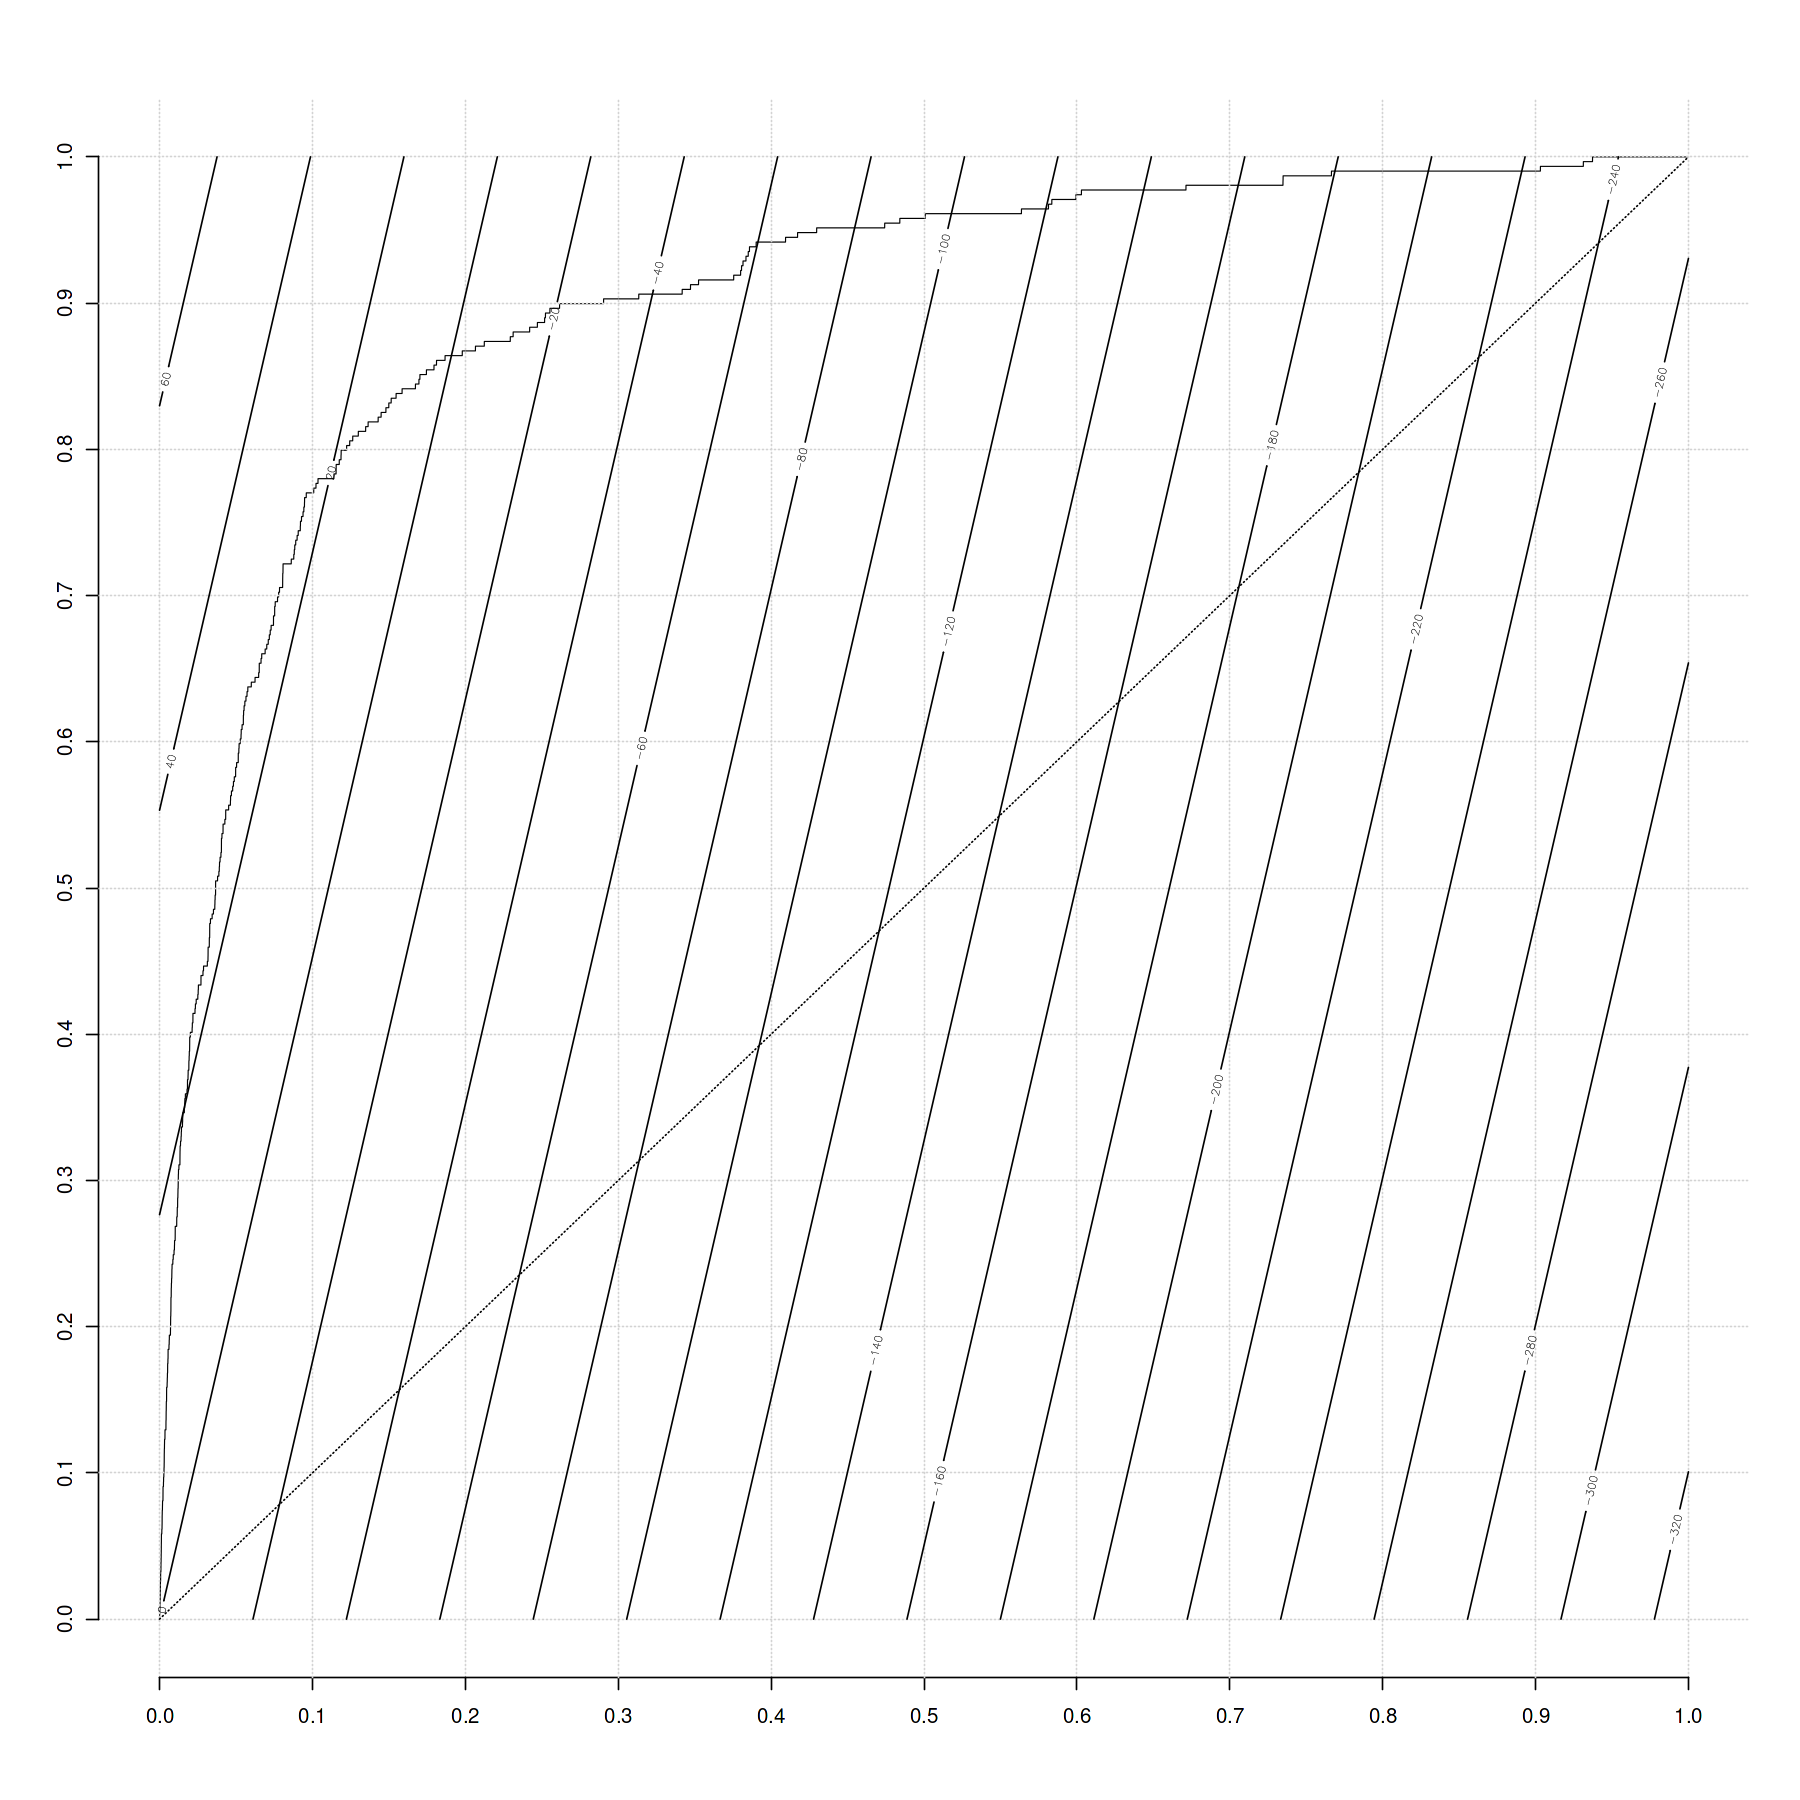

In [9]:
#ROC con curvas de nivel de ganancia
pred <- prediction(dtest$score, dtest[,clase])
perf <- performance(pred, measure = "tpr", x.measure = "fpr")

performance( pred,"auc")@y.values

tot_positivos = sum( dtest[,clase] )
tot_negativos = nrow(dtest) - sum( dtest[,clase] )

options(repr.plot.width=15, repr.plot.height=15)

plot.new()  
plot(perf,
       add = TRUE,
       lwd=.7,
       main="ROC Curves",
       avg = "vertical")
  grid(col="lightgray")
  axis(1, at=seq(0, 1, by=0.1))
  axis(2, at=seq(0, 1, by=0.1))
  abline(v=c(0.1, 0.3, 0.5, 0.7, 0.9), col="lightgray", lty="dotted")
  abline(h=c(0.1, 0.3, 0.5, 0.7, 0.9), col="lightgray", lty="dotted")
  lines(x=c(0, 1), y=c(0, 1), col="black", lty="dotted")

par( new=TRUE)
x <- seq(0, 1, len = 1500)
y <- seq(0, 1, len = 1500)

r <- outer(tot_negativos*x*kFPGain *3/1000000,tot_positivos*y*(kTPGain )*3/1000000,"+")

contour(r, axes = FALSE, nlevels = 15)

In [10]:
t0       <-  Sys.time()
modelo  <- ranger( data = dtrain,  
                   formula_obj,  
                   probability=TRUE,
                   num.trees= 900, 
                   min.node.size= 360, 
                   mtry= 4, 
                   splitrule='gini'
                 ) 
t1       <-  Sys.time()

tcorrida <-  as.numeric( t1 - t0, units = "secs")
print( tcorrida)


Growing trees.. Progress: 56%. Estimated remaining time: 24 seconds.
[1] 64.80281


In [11]:
#Calculo ganancia sobre dataset de pruebas
dapply$score <- predict(modelo, dapply, type = 'response')$predictions[,2]

#Selecciono los que estan por encima del umbral
dapply$Predicted <- dapply$score > 1/40


fwrite( dapply[ , list(numero_de_cliente, Predicted) ], #solo los campos para Kaggle
        file= "./exp/RANGER.csv", 
        sep= "," )